In [2]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Instructions
To run this notebook, you will need to download the Brainspan "Developmental Transcriptome Dataset", which can be found here: https://www.brainspan.org/static/download.html

Note where you save this data. May be simplest to put it in the ./data directory.



# Load brainspan data

I need to come back here and add the things I did to make these notebooks

In [3]:
# Where to save figures
fig_dir = './figures/'
bspan_dir = './data/'

In [4]:
df = pandas.read_csv(os.path.join(bspan_dir,'gene_expression_original.csv',)) # expression data
rmd = pandas.read_csv(os.path.join(bspan_dir,'gene_metadata_original.csv')) # rows metadata
cmd = pandas.read_csv(os.path.join(bspan_dir,'samples_metadata.csv')) # columns metadata

In [5]:
len(rmd.gene_symbol.unique())

47808

#### address duplicates

In [6]:
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

It appears most uniques are RNA or things we dont care about. I will remove them

In [7]:
df.shape

(52376, 525)

In [8]:
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
df.drop(bad_index,inplace=True)

# Harmonize datasets

#### Load component data

In [9]:
# We created this notebook in NB3_PLS_ModelExploration
all_comps = pandas.read_csv('./tables/all_comps_ROTATION.csv',index_col=0)

#### harmonize genes

In [11]:
shared = list(set(rmd.gene_symbol.values) & set(all_comps.gene_symbol))
len(shared)

13750

In [12]:
good_ids = rmd[rmd.gene_symbol.isin(shared)].index
gxp = df.loc[good_ids]
gxp.shape

(13750, 525)

In [13]:
gxp.index = rmd[rmd.gene_symbol.isin(shared)].gene_symbol.values
gxp.drop(gxp.columns[0],axis=1,inplace=True) # get rid of index column
gxp.head()

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
TSPAN6,36.447128,24.251253,19.330479,27.668607,19.998231,14.680673,27.548101,16.580183,44.587799,44.943915,...,2.320932,1.781548,2.277359,1.832737,1.555696,2.081944,3.484685,4.816781,3.034464,3.082820
DPM1,34.373239,20.765661,18.734947,22.366394,19.228431,11.020365,25.394607,17.671327,32.903100,38.157569,...,23.769167,20.142132,20.063257,16.575379,18.783516,21.631293,28.006120,28.731717,16.679597,28.866042
SCYL3,4.379337,4.227521,2.551825,3.603764,2.948976,2.405183,3.613642,2.573935,3.483817,3.609830,...,1.593009,1.563377,1.648571,2.231466,2.040326,2.161741,1.275352,1.184766,1.735579,1.500363
C1orf112,3.957119,3.520794,2.037805,3.487035,2.177235,0.999693,3.481555,1.747568,3.741580,3.560650,...,0.583488,0.797376,0.607141,0.575555,0.606445,0.683625,0.495084,0.761265,0.766482,0.468859
FGR,0.244174,0.266976,0.248188,0.141398,0.467688,0.296493,0.079941,0.149822,0.204210,0.260205,...,1.319251,2.062175,1.168233,0.681609,0.490367,0.407953,1.568014,1.260039,1.736395,1.632879


#### Get gene expression for each component and each columns

In [14]:
gdf = pandas.DataFrame(cmd,copy=True)

In [10]:
n_comps = 3

In [36]:
all_comps.index = all_comps.gene_symbol.values
for i,col in enumerate(gxp.columns):
    for c in range(1,(n_comps+1)):
        gdf.loc[i,'C%s_exp'%c] = np.dot(gxp[col],all_comps.loc[gxp.index,'C%s'%c].values)
    
    

In [17]:
## if you want to save the harmonized dataset, uncomment below
# gdf.to_csv('data/GCorr_Brainspan.csv')

In [11]:
## if you want to load your saved harmonized dataset, uncomment below
#gdf = pandas.read_csv('data/GCorr_Brainspan.csv')

#### Prepare stuff for plots

In [15]:
order = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw','4 mos','10 mos',
         '1 yrs', '2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']

# stage
fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs',]
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Stage'] = name

#epoch
e0 = ['8 pcw', '9 pcw']
e1 = ['12 pcw', '13 pcw', '16 pcw', '17 pcw', '19 pcw']
e2 = ['21 pcw','24 pcw', '25 pcw', '26 pcw', '35 pcw', 
      '37 pcw','4 mos']
e3 = ['10 mos','1 yrs','2 yrs', '3 yrs','4 yrs','8 yrs',
        '11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',
        '21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [e0,e1,e2,e3]
names = ['e0','e1','e2','e3']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Epoch'] = name

#period
p2 = ['8 pcw', '9 pcw']
p3 = ['12 pcw', '13 pcw',]
p4 = ['16 pcw']
p5 = ['17 pcw', '19 pcw']
p6 = ['21 pcw','24 pcw']
p7 = ['25 pcw', '26 pcw', '35 pcw','37 pcw']
p8 = ['4 mos']
p9 = ['10 mos','1 yrs']
p10 = ['2 yrs', '3 yrs','4 yrs',]
p11 = ['8 yrs','11 yrs',]
p12 = ['13 yrs', '15 yrs', '18 yrs', '19 yrs','21 yrs',
       '23 yrs','30 yrs', '36 yrs', '37 yrs','40 yrs']
divs = [p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
names = ['p2','p3','p4','p5','p6','p7','p8','p9',
         'p10','p11','p12']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.age.isin(div)].index,'Age_Period'] = name


In [16]:
# brain divisions

Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name
    
Tele = ['Ocx','AMY','M1C-S1C','MGE','STC',
                  'CGE','DTH','MFC','DFC','OFC','LGE',
                  'ITC','HIP','VFC','PCx','TCx','IPC',
                  'A1C','V1C','STR','M1C','S1C','MD']
Met = ['URL','CB','CBC']
divs = [Tele,Met]
names = ['Tele','Met']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'NT_Segment'] = name

Sensory = ['M1C-S1C','A1C','V1C','M1C','S1C']
Association = ['Ocx','AMY','STC','MFC',
            'DFC','OFC','ITC','HIP',
            'VFC','PCx','TCx','IPC']
Not_Cortex = ['MGE','URL','CGE','DTH',
          'LGE','STR','CB','CBC','MD']
divs = [Sensory,Association,Not_Cortex]
names = ['Sensory','Association','Not_Cortex']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    gdf.loc[gdf[gdf.structure_acronym.isin(div)].index,'Sensorifugal'] = name


In [17]:
# get log age
# deal with the nine months before birth before logging...
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    gdf.loc[i,'age_in_months'] = fage

In [18]:
# same thing for weeks
for i,row in gdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num)
    elif measure == 'yrs':
        fage = (int(num) * 52) + 39.105
    else:
        fage = (int(num) * 4.345) + 39.105
    gdf.loc[i,'age_in_weeks'] = fage

In [19]:
gdf.loc[:,'log_age_months'] = np.log(gdf['age_in_months']).values
gdf.loc[:,'log_age_weeks'] = np.log(gdf['age_in_weeks']).values


In [20]:
code = dict(zip(gdf.age.unique(),range(len(gdf.age.unique()))))
gdf.loc[:,'age_level'] = [code[x] for x in gdf.age.values]

# Plot component dispersion across brainspan

First we'll just look at regions at one side or the other of each gradient, to see how expression of the component in these regions changes over the lifespan

Text(0.5, 6.79999999999999, 'log age (weeks)')

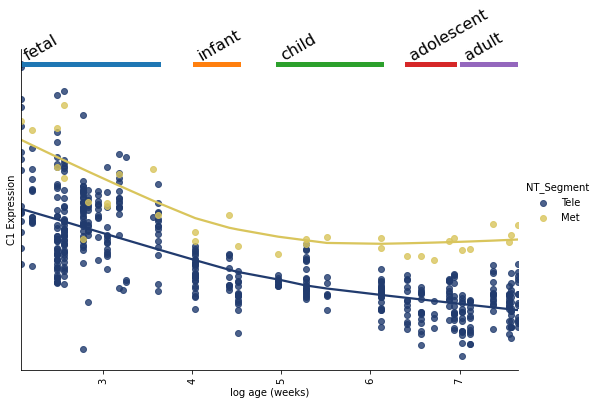

In [29]:
# C1

# plot
rbpal = [sns.color_palette('cividis')[-1],
                      sns.color_palette('cividis')[0]]
g = sns.lmplot(x='log_age_weeks',y='C1_exp',aspect=1.5,
               data=gdf,
               #[gdf['C1_exp']<1000],
           hue='NT_Segment',lowess=True,
              palette=rbpal[::-1])
g.set_xticklabels(rotation=90)

# decorate to show age stage in dataset 
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[5,5],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,5,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C1 Expression')
plt.yticks([])
plt.xlabel('log age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BS_Devel_C1.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log age (weeks)')

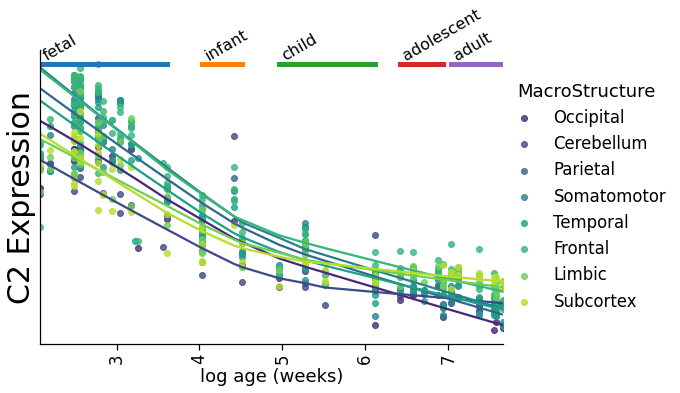

In [30]:
# C2
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='log_age_weeks',y='C2_exp',aspect=1.5,
               data=gdf[(gdf.MacroStructure!='GangEm') &\
                        (gdf['C2_exp']<1000)],
           hue='MacroStructure',lowess=True,
               hue_order=['Occipital','Cerebellum','Parietal','Somatomotor',
                          'Temporal','Frontal','Limbic','Subcortex'],
              palette='viridis')
g.set_xticklabels(rotation=90)
for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[10,10],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,10,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('log age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BS_Devel_C2.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log age (weeks)')

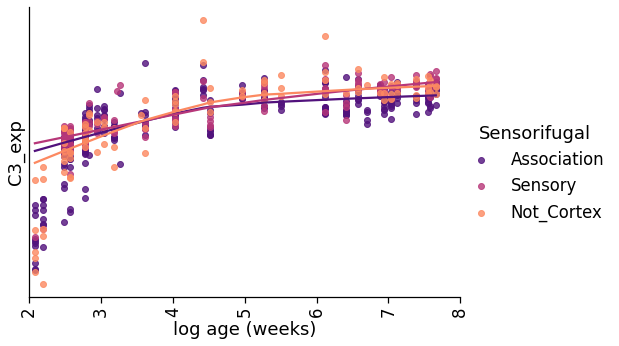

In [32]:
# c3
sns.set_context('notebook',font_scale=1.5)
g = sns.lmplot(x='log_age_weeks',y='C3_exp',aspect=1.5,
               data=gdf[gdf.C3_exp<400],
           hue='Sensorifugal',lowess=True,
              palette='magma')
g.set_xticklabels(rotation=90)
# for stage in gdf.Age_Stage.unique():
#     levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
#     xmin = np.min(levels)
#     xmax = np.max(levels)
#     plt.plot([xmin,xmax],[400,400],lw=5)
#     #loc = xmin + (xmax-xmin)*.5
#     plt.text(xmin,400,stage,fontsize=16,ha='left',
#              va='bottom',rotation=30)
# plt.ylabel('C2 Expression',fontsize=30)
plt.yticks([])
plt.xlabel('log age (weeks)')

#plt.savefig(os.path.join(fig_dir,'BS_Devel_C3.pdf'),bbox_inches='tight')

In [ ]:
all_comps.index=all_comps.gene_symbol.values

In [240]:
tgene.mean(0)

0       5.849807
1       5.270103
2       5.878423
3       5.534584
4       4.961010
         ...    
519     8.297337
520    16.376979
521    14.041919
522    25.348655
523    14.909795
Length: 524, dtype: float64

In [239]:
cutoff = round(((0.05/2)/3) * len(gxp))
bottom = all_comps.loc[gxp.index].sort_values('C1').gene_symbol.values[:cutoff]
top = all_comps.loc[gxp.index].sort_values('C1').gene_symbol.values[-cutoff:]
tgene = gxp.loc[top]
tgene

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
OLFML2A,0.914047,1.809604,1.186293,1.232191,5.000519,1.097516,1.180775,0.308168,0.683722,0.740407,...,0.347376,0.317135,1.185406,0.345379,0.442336,0.417839,0.386723,0.213455,0.877997,0.135616
GRM4,0.036085,0.075554,0.749632,0.240160,0.483444,3.716644,0.250650,0.278410,0.113173,0.008167,...,1.097824,46.431022,2.332833,1.128888,1.254942,0.968932,0.985265,0.553864,5.348920,1.146141
EYA4,0.004016,0.020191,0.078175,0.089344,0.032946,0.046325,0.070572,0.149805,0.065358,0.043407,...,0.115826,0.031100,0.441801,0.162593,0.217373,0.114159,0.183896,0.077201,0.268519,0.106511
INPP4B,0.139533,0.184772,0.419630,0.263494,0.443073,0.212177,0.129820,0.119703,0.171636,0.258662,...,0.802840,0.903641,2.282991,1.569104,1.678347,1.673960,0.690168,1.244737,1.823755,0.930904
GABRE,0.026183,0.053190,0.077524,0.045315,0.070449,0.186401,0.025766,0.046580,0.065693,0.030466,...,0.069469,0.000000,0.255208,0.173345,0.158589,0.205521,0.101695,0.188194,0.086485,0.075959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC17A6,3.084331,4.505897,3.260110,0.493094,6.262814,8.535775,1.241720,26.287054,6.145532,8.941117,...,4.366398,0.000000,8.360177,5.356874,9.593716,9.272812,3.566031,8.021142,0.022545,5.753604
ARL9,1.329209,2.226612,8.140388,3.445669,2.719889,8.427871,4.253348,5.419253,2.305464,2.823938,...,3.649269,2.763219,5.117942,1.445764,1.939637,1.843399,2.095607,1.994891,0.845656,1.326377
ST3GAL6,1.418143,1.066632,0.598596,0.760052,1.175184,1.357559,1.021309,1.111628,1.333589,1.258194,...,4.286161,3.120708,5.661703,2.767949,4.084929,4.061578,3.753903,3.689927,1.510303,4.528467
LXN,5.688562,4.146503,3.587871,3.044589,3.453939,1.843489,3.219462,2.431132,4.425014,7.861750,...,2.170438,5.155947,2.783928,1.330495,1.557983,1.535817,1.207739,3.011081,2.229449,1.557066


In [339]:
for c in range(1,4):
    cutoff = round(((0.05/2)/3) * len(gxp))
    bottom = all_comps.sort_values('C%s'%c).gene_symbol.values[:cutoff]
    bottom = [x for x in bottom if x in gxp.index]
    top = all_comps.loc[gxp.index].sort_values('C%s'%c).gene_symbol.values[-cutoff:]
    top = [x for x in top if x in gxp.index]
    gdf.loc[:,'C%s_topgenes'%c] = gxp.loc[top].mean(0).values
    gdf.loc[:,'C%s_botgenes'%c] = gxp.loc[bottom].mean(0).values 

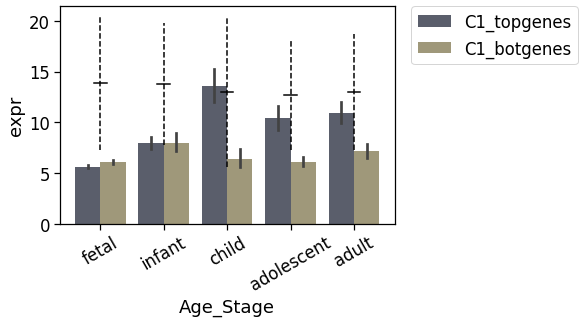

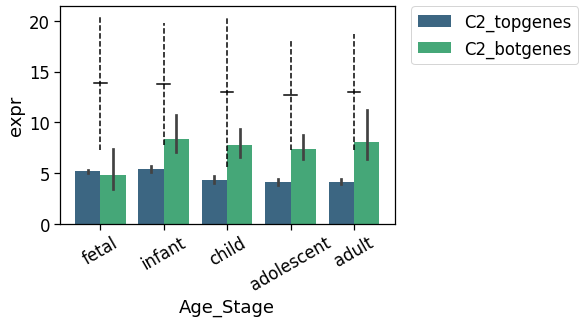

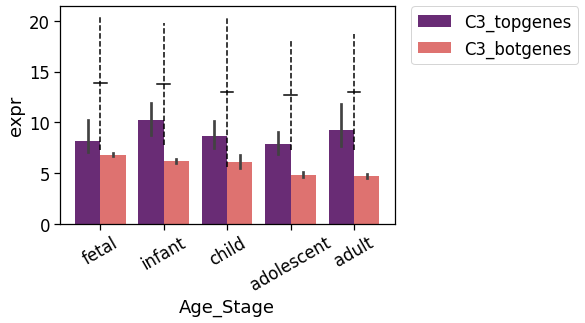

In [348]:
avgs = {}
for i,s in enumerate(gdf.Age_Stage.unique()):
    mval = gxp[gdf[gdf.Age_Stage==s]['column_num']].mean().mean()
    sval = gxp[gdf[gdf.Age_Stage==s]['column_num']].std(1).mean()
    avgs.update({i:[mval,sval]})

#for x in ['C1_topgenes','C1_botgenes','C2_topgenes','C2_botgenes','C3_topgenes','C3_botgenes']:
for c in range(1,4):
    forplot = gdf.melt(id_vars='column_num',value_vars=['C%s_topgenes'%c,'C%s_botgenes'%c],
                     var_name='tail',value_name='expr')
    forplot.loc[:,'Age_Stage'] = gdf.Age_Stage.tolist() * 2
    g=sns.barplot(x='Age_Stage',y='expr',data=forplot,hue='tail',palette=pals[c-1])
    g.set_xticklabels(g.get_xticklabels(),rotation=30)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #sns.swarmplot(x='Age_Stage',y=x,data=gdf,color='k',alpha=0.3)
    for i,vals in avgs.items():
        plt.plot([i-0.1,i+0.1],[vals[0],vals[0]],ls='-',c='k')
        plt.plot([i,i],[vals[0]-vals[1],vals[0]+vals[1]],ls='--',c='k')
    plt.show()

In [333]:
fetal = gxp[gdf[gdf.Age_Stage=='fetal']['column_num']]
fetal = pandas.DataFrame(StandardScaler().fit_transform(fetal),
                 index=fetal.index,columns=fetal.columns)

In [349]:
tgenes = {}
alltgs = []
for i in range(1,4):
    genes = all_comps.sort_values('C%s'%i).head(130).gene_symbol.values
    genes = [x for x in genes if x in gxp.index]
    tgenes.update({'C%s_head'%i:genes})
    alltgs += list(genes)
    genes = all_comps.sort_values('C%s'%i).tail(130).gene_symbol.values
    genes = [x for x in genes if x in gxp.index]
    tgenes.update({'C%s_tail'%i:genes})
    alltgs += list(genes)

(0.0, 500.0)

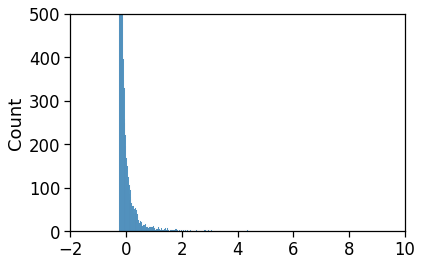

In [360]:
sns.histplot(fetal.mean(1))
plt.xlim(-2,10)
plt.ylim(0,500)

C1_head


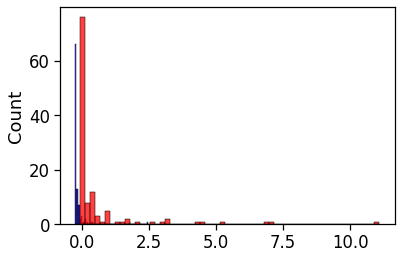

C1_tail


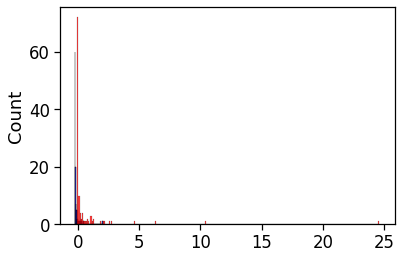

C2_head


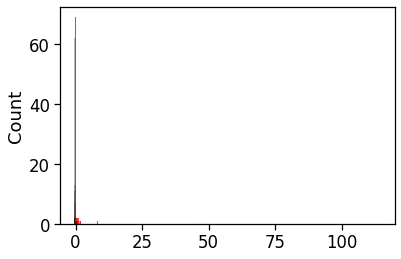

C2_tail


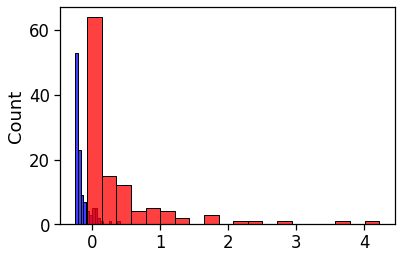

C3_head


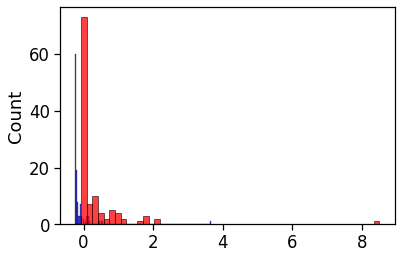

C3_tail


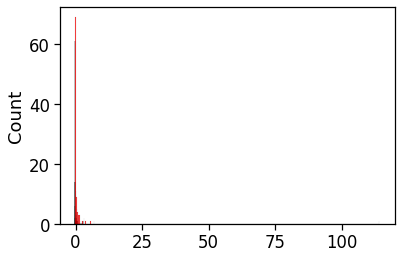

In [357]:
for nm,genes in tgenes.items():
    print(nm)
    sns.histplot(fetal.loc[genes].mean(1).values,color='blue')
    sns.histplot(fetal.loc[genes].max(1).values,color='red')
    plt.show()

In [385]:
bvar = pandas.ExcelFile('/Users/jacobv/Science/PLS_GXP/rising_falling_genes.xlsx'
                       ).parse('ExpressedGenes_23782')

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [386]:
dups = []
dind = []
catch = []
for i,row in bvar.iterrows():
    x = row['GeneSymbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

In [387]:
bvar.drop(dind,inplace=True)

In [388]:
bvar.index = bvar.GeneSymbol.values

In [389]:
len(bvar.GeneSymbol.values)

23737

In [390]:
len(bvar.GeneSymbol.unique())

23737

In [392]:
genedf = pandas.DataFrame(index = gxp.index)
shared = set(genedf.index) & set(bvar.index)
genedf.loc[shared,'trajectory'] = bvar.loc[shared,'Trajectory_group'].values
genedf.loc[:,'trajectory'] = [x if pandas.notnull(x) else 'Missing' \
                              for x in genedf.trajectory.values]

In [397]:
tgenes.keys()

dict_keys(['C1_head', 'C1_tail', 'C2_head', 'C2_tail', 'C3_head', 'C3_tail'])

In [415]:
tdf.value_counts()

trajectory      
Rising              70
Non-transitional    31
Falling             13
Missing              6
dtype: int64

In [417]:
tdf[tdf.trajectory!='Missing']

,trajectory
PRRX1,Rising
WFDC1,Rising
CTXN3,Rising
GPR20,Rising
ASGR2,Rising
...,...
LCE3C,Non-transitional
TIPARP,Non-transitional
CMAHP,Rising
GNA14,Rising


In [426]:
traj = pandas.DataFrame()
i = 0
for k,v in tgenes.items():
    tdf = pandas.DataFrame(genedf.loc[v,'trajectory'])
    tvals = tdf.value_counts() / len(tdf[tdf.trajectory!='Missing'])
    for gp,prop in tvals.items():
        if gp[0] == 'Missing': continue
        traj.loc[i,'component'] = k.split('_')[0] + ' Genes'
        traj.loc[i,'tail'] = k.split('_')[1]
        traj.loc[i,'group'] = gp
        traj.loc[i,'proportion'] = prop
        i += 1 
    
tdf = pandas.DataFrame(genedf)
tvals = tdf.value_counts() / len(tdf[tdf.trajectory!='Missing'])
for gp,prop in tvals.items():
    if gp[0] == 'Missing': continue
    traj.loc[i,'component'] = 'All Genes'
    traj.loc[i,'tail'] = 'tail'
    traj.loc[i,'group'] = gp
    traj.loc[i,'proportion'] = prop
    i += 1 

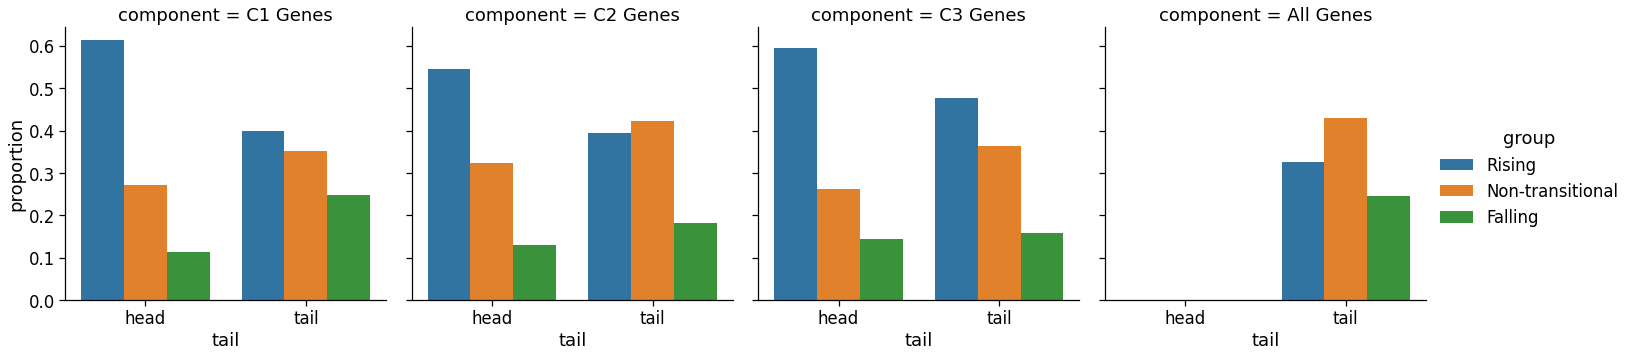

In [427]:
sns.catplot(data=traj,kind='bar',x='tail',y='proportion',hue='group',col='component')

In [405]:
tvals = genedf.trajectory.value_counts()
tvals /= len(genedf[genedf.trajectory!='Missing'])
for i,row in tvals.items():
    print(i,row)

Non-transitional 0.4297195210158322
Rising 0.32532347504621073
Falling 0.24495700393795708
Missing 0.1050389777384875


In [394]:
genedf.loc[alltgs,'trajectory'].value_counts()

Rising              324
Non-transitional    212
Falling             104
Missing              42
Name: trajectory, dtype: int64

In [373]:
jnk = set(alltgs) & set(bvar.GeneSymbol.values)
bvar[bvar.GeneSymbol.isin(jnk)].Cell_type_marker.value_counts()

.                           510
Fetal_Inhibitory_Neurons      4
OPC_Astro                     2
Fetal_Excitatory_Neurons      2
Adult_Inhibitory_Neurons      1
Name: Cell_type_marker, dtype: int64

# Comparison to adult

In NB3_PLS_ModelExploration, we generated component expression for Allen Brain Atlas data reduced to a low resolution (so as to better match the brainspan resolution). Here, we will load this data to compare regional expression of each component across the two datasets

#### Initialize some stuff

In [31]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data_ROTATION.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure2.unique()))
print('missing:',set(gdf.MacroStructure2.unique()) - set(abac2.index))

shared: {'Occipital', 'Frontal', 'Thalamus', 'Temporal', 'Limbic', 'Parietal', 'Cerebellum', 'Sensorimotor', 'Striatum'}
missing: {'GangEm'}


In [32]:
bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure2',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure2==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

In [33]:
c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,2.072421,0.430684,-0.706893,0.019982,Cerebellum
Frontal,4.278755,0.291527,0.789432,0.031165,Frontal
Limbic,3.157366,0.325267,0.030956,0.039398,Limbic
Occipital,2.999114,0.534507,-1.655174,0.042085,Occipital
Parietal,3.628336,0.597976,-1.124981,0.031968,Parietal


#### Do cross-dataset comparison

In [34]:
# z-score data to account for standardized vs. non-standardize nature of the two datasets
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals

In [35]:
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

r = 0.981, p = 0.0


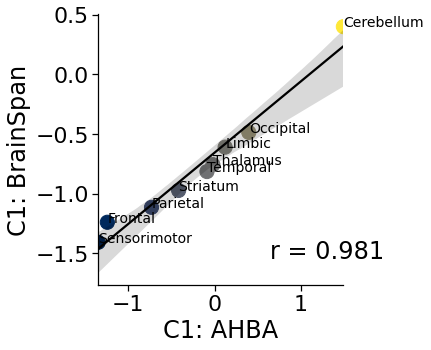

r = 0.953, p = 0.0


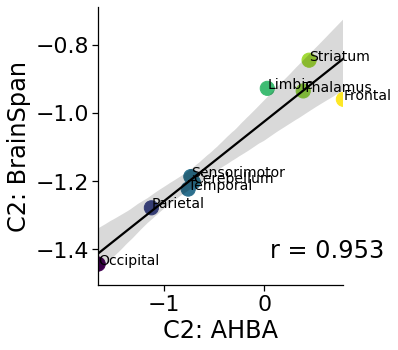

r = 0.913, p = 0.001


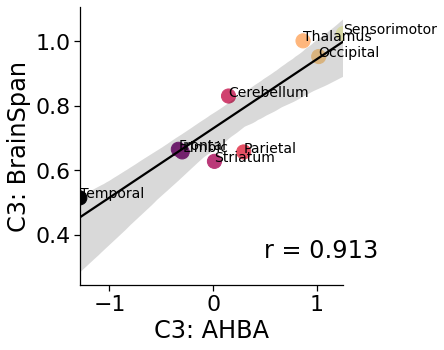

In [36]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Age_Stage=='adult'],# just the adults!
                          values='zC%s_exp'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = gdf[gdf.MacroStructure2==div]['zC%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.BS_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'BS_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: BrainSpan'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    #plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(fig_dir,'BrSp_Repl_C%s_ROTATED.pdf'%i), bbox_inches='tight')
    plt.show()

# Individual subject matching

We can do the same analysis above, except this time, we can compare regional component expression of individual subjects to those of Allen Brain Atlas. That way, we can track how individual variables (like age) related to how well the components replicate.

In [48]:
# create individual dfs for each component
gpdfs = {}
for i in range(1,(n_comps+1)):
    gpdf = gdf[['donor_id','C%s_exp'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='C%s_exp'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [40]:
# example. We see there is missing data for different donors
print(gpdfs[1].shape)
gpdfs[1].head()

(42, 10)


MacroStructure2,Cerebellum,Frontal,Limbic,Occipital,Parietal,Sensorimotor,Striatum,Temporal,Thalamus,n_valid
donor_id,,,,,,,,,,
12287,NaN,1.949341,NaN,2.185321,1.871360,NaN,1.018892,2.000375,1.589754,6.0
12288,2.298438,1.890291,0.778550,2.422554,1.973343,1.651394,0.952727,2.428280,1.933007,9.0
12289,0.759642,-0.471829,0.310170,0.233977,-0.206816,-0.769696,NaN,-0.029299,NaN,7.0
12290,1.464578,-0.302466,0.307675,0.569582,-0.116053,-0.517127,0.054621,0.112675,-0.056059,9.0
12295,2.585545,1.524844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [41]:
# how many people are missing how much data?
gpdfs[1].n_valid.value_counts()

9.0    18
8.0     9
7.0     6
6.0     3
4.0     2
2.0     2
3.0     1
1.0     1
Name: n_valid, dtype: int64

In [49]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions

# for each component
for c in range(1,(n_comps+1)):
    # prep data
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [53]:
# build a summary dataframe at the indexed by subjects

cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().loc[gpdfs[1].index].values
for c in range(1,(n_comps+1)):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

In [55]:
subsum.to_csv('data/subsum.csv')

r=0.738, p=0.0


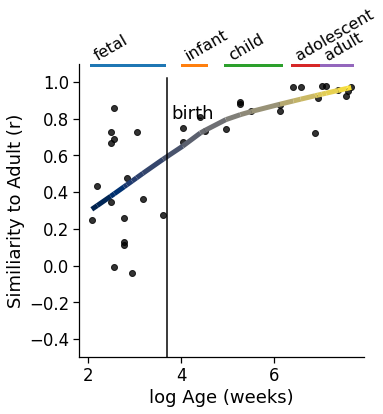

r=0.794, p=0.0


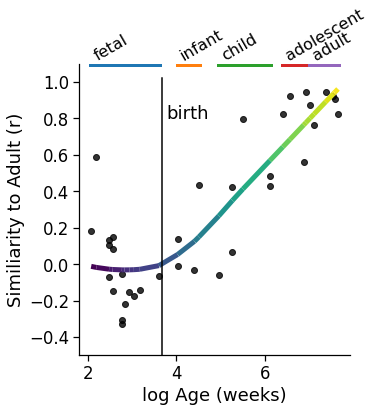

r=0.616, p=0.0001


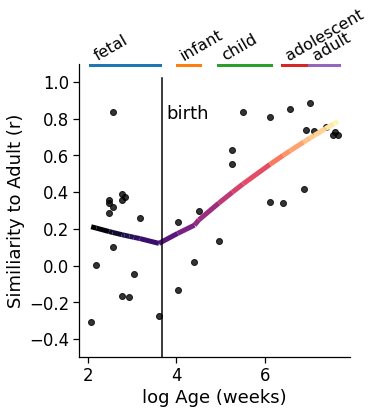

In [54]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 

sns.set_context('notebook',font_scale=1.5)
# for each component
for c in range(1,(n_comps+1)):
    # plot
    g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'age_level']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
    # make line purty
    x, y = g.ax.get_lines()[0].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    g.ax.get_lines()[0].remove()
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
    
    # decorate so age stage is indicated
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.5,1.1)
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.8,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



In [62]:
devplot[devplot.Component=='1']

,r,Component,age_level,age_stage,age_in_months,log_age_months,age_in_weeks,log_age_weeks
0,0.128314,1,4,fetal,3.678161,1.302413,16.000,2.772589
1,0.362348,1,8,fetal,5.517241,1.707878,24.000,3.178054
2,0.974661,1,20,adolescent,132.000000,4.882802,611.105,6.415269
3,0.958808,1,27,adult,360.000000,5.886104,1599.105,7.377199
4,NaN,1,11,fetal,8.045977,2.085172,35.000,3.555348
5,0.747807,1,13,infant,4.000000,1.386294,56.485,4.033975
6,0.843130,1,18,child,48.000000,3.871201,247.105,5.509813
7,NaN,1,22,adolescent,180.000000,5.192957,819.105,6.708212
8,0.980644,1,26,adult,276.000000,5.620401,1235.105,7.118911
9,0.921701,1,28,adult,432.000000,6.068426,1911.105,7.555437


In [169]:
46.90 + 22.79

69.69

In [56]:
# Let's plot all those lines on one plot
devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_stage'] = subsum.Age_Stage.tolist() * 3
devplot.loc[:,'age_in_months'] = subsum.age_in_months.tolist() * 3
devplot.loc[:,'log_age_months'] = subsum.log_age_months.tolist() * 3
devplot.loc[:,'age_in_weeks'] = subsum.age_in_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3

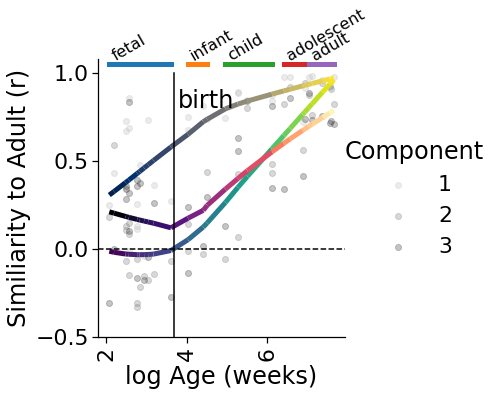

In [284]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
             hue_order=['1','2','3'],palette='binary',
               data=devplot,scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.5,1.08)
g.set_xticklabels(rotation=90)
for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.8,'birth')
#plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay_ROTATED.pdf'),bbox_inches='tight')

Text(0.5, 15.439999999999998, 'log Age (weeks)')

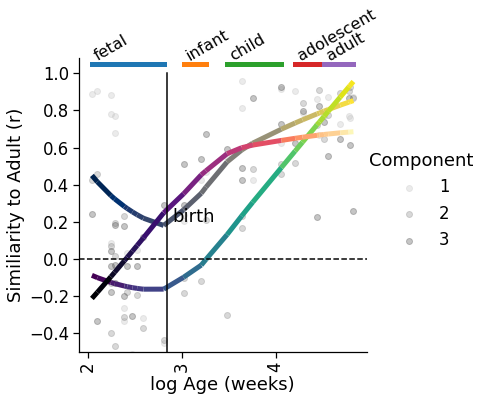

In [68]:
g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
             hue_order=['1','2','3'],palette='binary',
               data=devplot,scatter_kws={'alpha':0.3})
g.ax.set_ylim(-0.5,1.08)
g.set_xticklabels(rotation=90)
for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap=pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for stage in gdf.Age_Stage.unique():
    levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    #loc = xmin + (xmax-xmin)*.5
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,ls='--',c='k')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.2,'birth')
#plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (weeks)')
#plt.savefig(os.path.join(fig_dir,'BrSp_CompR_overlay_ROTATED.pdf'),bbox_inches='tight')

# Save progress
(for other notebooks)

In [34]:
gdf.to_csv('data/brainspan.csv')

# Comparison to GTex
Note: The GTEx_Workup notebook should be run before proceeding to this part

In [161]:
# load GTEx derivatives from GTEx_Workup.ipynb notebook
gss = pandas.read_csv('data/GTEx_IndivCongruence_ROTATION_again.csv',index_col=0)

In [162]:
# Need to re-establish excluded subjects, as we did before in the GTEx notebook
#basedf = pandas.read_csv('data/GTEx_brain_norm_noregress_meta.csv')
basedf = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress_meta.csv')
excludf = pandas.read_csv('data/GTEx_healthy.csv',index_col=0)
excludf.loc[:,'Healthy'] = [x.replace('.','-') for x in excludf.Healthy.values]
dx_exclude = list(set(basedf.SUBJID.values) - set(excludf.Healthy.values))
gss.loc[gss.SUBJID.isin(dx_exclude),'Excl_Dx'] = 1
gss.loc[gss.Excl_Dx!=1,'Excl_Dx'] = 0

In [163]:
# Merge the Brainspan and GTEx dataframes
d1 = pandas.DataFrame(gss[['AGE','SEX','C1_r','C2_r','C3_r','n_valid','Excl_Dx']],
                      copy=True)
d1.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','Excl_Dx']
d1.loc[:,'cohort'] = 'GTEx'
d1.loc[:,'age_in_months'] = (d1.loc[:,'age'] * 12)+9
d1.loc[:,'age_in_weeks'] = (d1.loc[:,'age'] * 52)+40

d2 = pandas.DataFrame(subsum[['age','gender','C1_r','C2_r',
                              'C3_r','n_valid','age_in_months','age_in_weeks']],
                     copy=True)
d2.columns = ['age','sex','C1_r','C2_r','C3_r','nvalid','age_in_months','age_in_weeks']
d2.loc[:,'cohort'] = 'BrainSpan'

dsmerge = pandas.concat([d1,d2])

In [164]:
# calculate log age and reset index
dsmerge.loc[:,'logAge'] = np.log(dsmerge.loc[:,'age_in_weeks'].values)
dsmerge.loc[:,'old_ind'] = dsmerge.index
dsmerge.index = range(len(dsmerge))

In [165]:
gxp.shape

(13750, 524)

In [166]:
# calculate decade
for i,row in dsmerge.iterrows():
    age = row['age_in_months'] / 12
    if age < 0.72:
        decade = 0
    elif age < 2:
        decade = 0.1
    elif age < 9:
        decade = 0.5
    else:
        decade = round(age/10)
    dsmerge.loc[i,'decade'] = decade

In [167]:
# put together plotting spreadsheets
ages = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].logAge.tolist() * 3)
rs = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].C1_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C2_r.tolist() +\
                   dsmerge[dsmerge.cohort=='GTEx'].C3_r.tolist())
n = len(dsmerge[dsmerge.cohort=='GTEx'])
comp = pandas.Series(['C1']*n + ['C2']*n + ['C3']*n)
decade = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].decade.tolist() * 3)
excl = pandas.Series(dsmerge[dsmerge.cohort=='GTEx'].Excl_Dx.tolist() * 3)
gtplotr = pandas.concat([ages,rs,comp,decade,excl],axis=1)
gtplotr.columns = ['logAge','r','component','decade','excl_dx']


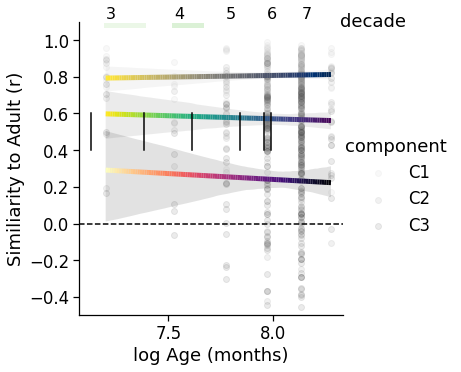

In [168]:
# Make the GTEx plots
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr,
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.5,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
# plt.savefig(os.path.join(fig_dir,'GTEx_logAge_ROTATED.pdf'),bbox_inches='tight')

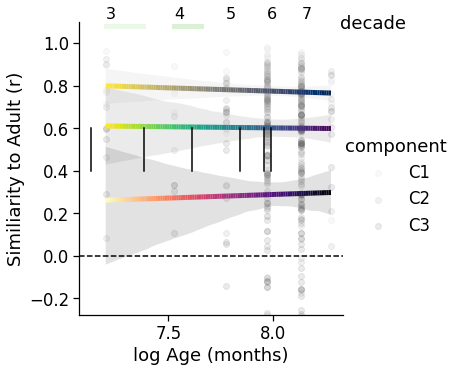

In [203]:
# now repeat after excluding all people who died with a brain-related clinical diagnosis
sns.set_context('notebook',font_scale=1.5)
pal = sns.color_palette('Greens',len(dsmerge.decade.unique()))
g=sns.lmplot(x='logAge',y='r',hue='component',data=gtplotr[gtplotr.excl_dx==0],
          scatter_kws={'alpha':0.1},palette='binary')
plt.axhline(0,ls='--',c='k')
plt.ylim(-0.28,1.1)
plt.ylabel('Similiarity to Adult (r)')
plt.xlabel('log Age (months)')

for i in range(3):
    # make line purty
    x, y = g.ax.get_lines()[i].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    norm = plt.Normalize(x.min(), x.max())
    lc = LineCollection(segments, cmap='%s_r'%pals[i], norm=norm)
    lc.set_array(x[:-1])
    lc.set_linewidth(2)
    line = g.ax.add_collection(lc)
    plt.setp(line,linewidth=5)
for i in range(3):
    g.ax.get_lines()[0].remove()

for i,dec in enumerate(sorted(gtplotr.decade.unique())):
    if dec == 8: continue
    levels = dsmerge[dsmerge.decade==dec]['logAge'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.08,1.08],lw=5,c=pal[i])
    #loc = xmin + (xmax-xmin)*.5
    if dec >= 1:
        lab = int(dec)
    else:
        lab = dec
    plt.text(xmin,1.1,lab,fontsize=16,ha='left',
             va='bottom',rotation=0)
plt.text(xmax+0.5,1.05,'decade',ha='right',va='bottom')
allen_ages = [57,31,49,55,24,39]
for aa in allen_ages:
    la = np.log((aa*52))
    plt.plot([la,la],[0.4,0.6],c='k')
#plt.savefig(os.path.join(fig_dir,'GTEx_logAge_ctrl.pdf'),bbox_inches='tight')

In [63]:
dsmerge.to_csv('BrainSpan_GTEx_PLSC_similarity.csv')

# Use brainspan-specific model and direct prediction/transformation

In [21]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [22]:
hbigdf = hbigdf[gxp.index]

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
#MinMaxScaler().fit_transform(gxp)

In [24]:
from sklearn.decomposition import PCA
# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error

pls_mod = PLSRegression(n_components=3)
pred = cross_val_predict(pls_mod,pca_tfm,full_y,cv=10)
#sns.regplot(pred,full_y)
print('r2_score =',r2_score(full_y,pred))
print('mae =',mean_absolute_error(full_y,pred))

NameError: name 'PLSRegression' is not defined

In [ ]:
all_comps.index = all_comps.gene_symbol.values

In [27]:
for col in ['C1','C2','C3']:
    all_comps.loc[:,'abs_%s'%col] = abs(all_comps[col].values)
    all_comps.sort_values('abs_%s'%col,inplace=True,ascending=False)
    all_comps.loc[:,'%sind'%col] = range(len(all_comps))
    print('****',col,'****')
    pos = [x for x in all_comps.sort_values('abs_%s'%col,ascending=True
                                          ).index[:130] if x in shared]
    neg = [x for x in all_comps.sort_values('abs_%s'%col).index[:130] if x in shared]
    print('%s%% positive genes, %s%% negative genes present'%(round(((len(pos)/130)*100),2),
                                                              round(((len(neg)/130)*100),2)))
    weight_ratio = sum(all_comps.loc[shared]['abs_%s'%col].values) /\
                   sum(all_comps['abs_%s'%col].values)
    print('%s%% of weight accounted for \n'%round(weight_ratio*100,2))

**** C1 ****
86.15% positive genes, 86.15% negative genes present
88.24% of weight accounted for 

**** C2 ****
86.92% positive genes, 86.92% negative genes present
88.22% of weight accounted for 

**** C3 ****
86.92% positive genes, 86.92% negative genes present
88.25% of weight accounted for 



In [19]:
from sklearn.cross_decomposition import PLSRegression
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [20]:
hb_pcatfm = pcamod.transform(MinMaxScaler().fit_transform(gxp).T)
preds = pls_mod.predict(hb_pcatfm)

In [51]:
preds.shape

(524, 3)

In [21]:
gdf.loc[:,'predicted_y'] = preds[:,0]
gdf.loc[:,'predicted_z'] = preds[:,1]
gdf.loc[:,'predicted_x'] = preds[:,2]

In [58]:
gdf.columns

Index(['column_num', 'donor_id', 'donor_name', 'age', 'gender', 'structure_id',
       'structure_acronym', 'structure_name', 'Age_Stage', 'Age_Epoch',
       'Age_Period', 'MacroStructure', 'MacroStructure2', 'NT_Segment',
       'Sensorifugal', 'C1_exp', 'C2_exp', 'C3_exp', 'age_in_months',
       'age_in_weeks', 'log_age_months', 'log_age_weeks', 'age_level',
       'predicted_y', 'predicted_z', 'predicted_x'],
      dtype='object')

fetal


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


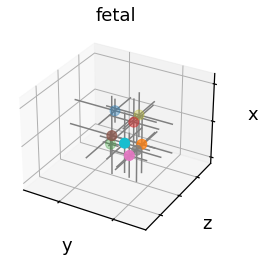

infant


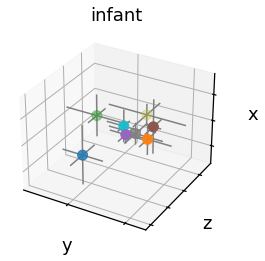

child


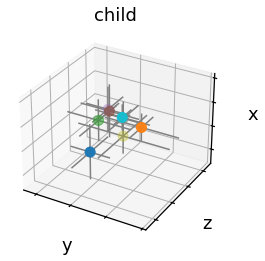

adolescent


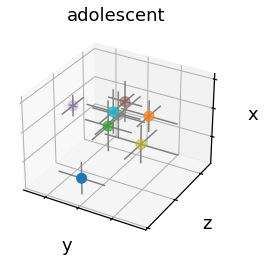

adult


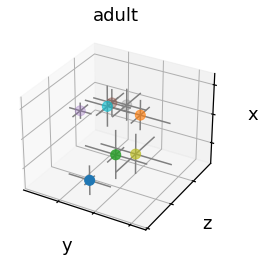

In [76]:
sns.set_context('notebook',font_scale=1.5)

# for each age group separately
for agp in gdf.Age_Stage.unique():
    if not pandas.notnull(agp): continue
    print(agp)
    adf = gdf[gdf.Age_Stage==agp]
    # get means and sds across donors
    means = adf.groupby('MacroStructure')[['predicted_y','predicted_z','predicted_x']].mean()
    stds = adf.groupby('MacroStructure')[['predicted_y','predicted_z','predicted_x']].std()
    stds.columns = ['y_sd','z_sd','x_sd']
    # set up plotting dataframe for easy reference
    plotr = pandas.concat([means,stds],axis=1)
    plotr.loc[:,'region'] = plotr.index
    # start building plot
    ax = plt.axes(projection='3d')
    # plot confidence intervals across all three dimensions
    for i,row in plotr.iterrows():
        y_mn = row['predicted_y']
        z_mn = row['predicted_z']
        x_mn = row['predicted_x']
        y_sd = row['y_sd']
        z_sd = row['z_sd']
        x_sd = row['x_sd']
        ax.plot3D([y_mn-y_sd,y_mn+y_sd], [z_mn,z_mn], [x_mn,x_mn], 'gray')
        ax.plot3D([y_mn,y_mn], [z_mn-z_sd,z_mn+z_sd], [x_mn,x_mn], 'gray')
        ax.plot3D([y_mn,y_mn], [z_mn,z_mn], [x_mn-x_sd,x_mn+x_sd], 'gray')
    # plot markers
    ax.scatter3D(plotr.predicted_y, plotr.predicted_z, plotr.predicted_x, c=range(len(plotr)),cmap='tab10',
                s=100)
    # decorate
    plt.xlabel('y')
    plt.ylabel('z')
    ax.set_zlabel('x')
    ax.set_xticklabels(['' for x in ax.get_xticklabels()])
    ax.set_yticklabels(['' for x in ax.get_yticklabels()])
    ax.set_zticklabels(['' for x in ax.get_zticklabels()])
    ax.set_title(agp)
    plt.show()

array(['fetal', 'infant', 'child', 'adolescent', 'adult'], dtype=object)

fetal


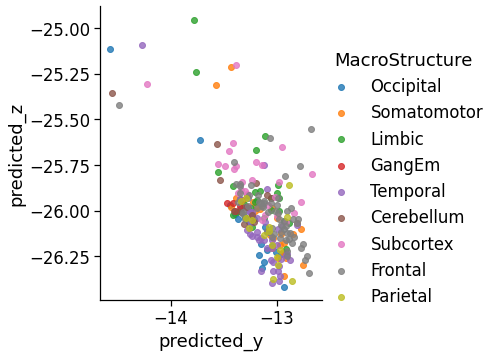

infant


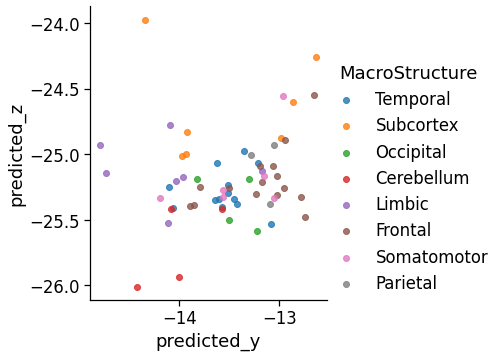

child


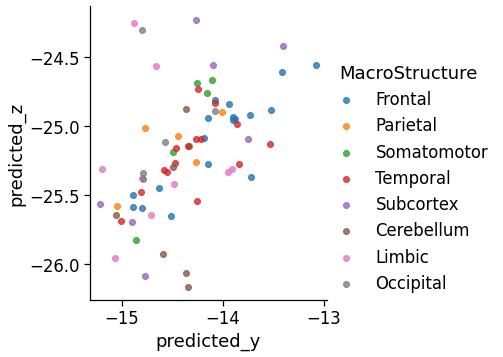

adolescent


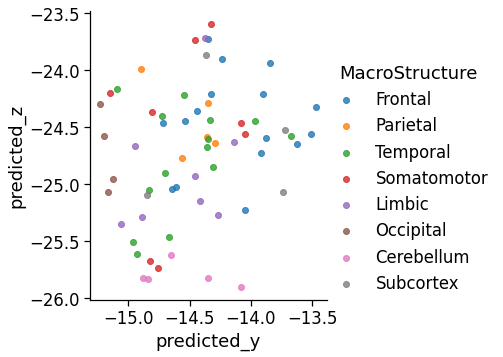

adult


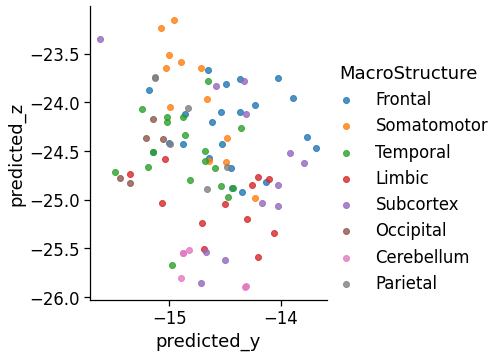

In [81]:
for stage in gdf.Age_Stage.unique():
    print(stage)
    sns.lmplot(x='predicted_y',y='predicted_z',
               data=gdf[gdf.Age_Stage==stage],
               hue='MacroStructure',fit_reg=False)
    plt.show()
    

In [84]:
g2=pandas.read_csv('data/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)
g2.drop(g2.columns[0],axis=1,inplace=True)
g2 = g2.loc[hgdf.index]

In [90]:
g2.brain_divison.unique()

array(['Sensorimotor', 'Insula', 'Thalamus', 'Limbic', 'DCN', 'Striatum',
       'Forebrain', 'Tegmentum', 'Temporal', 'Frontal',
       'Posterior_Cingulate', nan, 'Parietal', 'Anterior_Cingulate',
       'Occipital', 'Hypothalamus', 'Pons', 'Medulla', 'Cerebellum',
       'Tectum', 'Other_Dien'], dtype=object)

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6768550935561842 0.04523730948654466


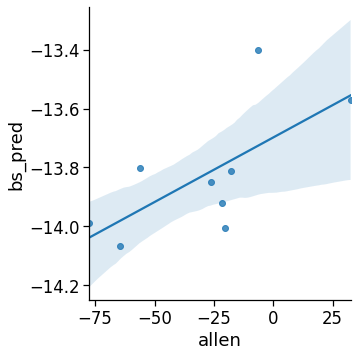

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.7309886185539292 0.0252544402353883


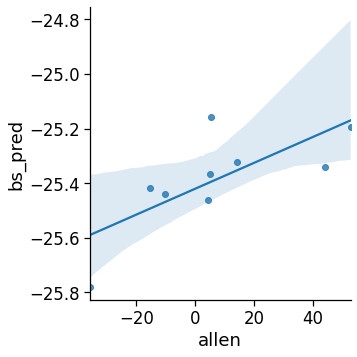

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.8885452055126158 0.0013625727220453066


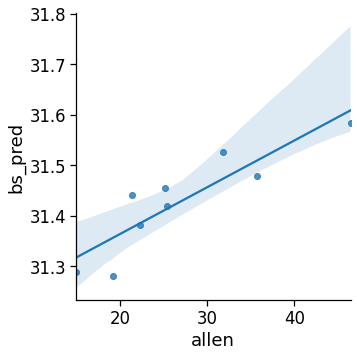

In [111]:
goodregs = set(gdf.MacroStructure2.unique()) & set(g2.brain_divison.unique())
abay = g2[g2.brain_divison.isin(goodregs)].groupby('brain_divison')['mni_nlin_y'].mean()
bsy = gdf[gdf.MacroStructure2.isin(goodregs)].groupby('MacroStructure2')['predicted_y'].mean()
plotr=pandas.concat([abay,bsy],axis=1)
plotr.columns = ['allen','bs_pred']
plotr.loc[:,'region'] = goodregs
sns.lmplot('allen','bs_pred',data=plotr,)
r,p = stats.pearsonr(abay,bsy)
print(r,p)
plt.show()

abaz = g2[g2.brain_divison.isin(goodregs)].groupby('brain_divison')['mni_nlin_z'].mean()
bsz = gdf[gdf.MacroStructure2.isin(goodregs)].groupby('MacroStructure2')['predicted_z'].mean()
plotr=pandas.concat([abaz,bsz],axis=1)
plotr.columns = ['allen','bs_pred']
plotr.loc[:,'region'] = goodregs
sns.lmplot('allen','bs_pred',data=plotr,)
r,p = stats.pearsonr(abaz,bsz)
print(r,p)
plt.show()

abax = g2[g2.brain_divison.isin(goodregs)].groupby('brain_divison')['abs_mni_nlin_x'].mean()
bsx = gdf[gdf.MacroStructure2.isin(goodregs)].groupby('MacroStructure2')['predicted_x'].mean()
plotr=pandas.concat([abax,bsx],axis=1)
plotr.columns = ['allen','bs_pred']
plotr.loc[:,'region'] = goodregs
sns.lmplot('allen','bs_pred',data=plotr,)
r,p = stats.pearsonr(abax,bsx)
print(r,p)
plt.show()

In [170]:
# create individual dfs for each dimension
dims = dict(zip(['predicted_y','predicted_z','predicted_x'],
               ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']))
gpdfs = {}
for bdim,adim in dims.items():
    gpdf = gdf[['donor_id',bdim,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values=bdim)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({bdim: gpdf})

In [117]:
aba

MacroStructure2
Cerebellum     -64.370175
Frontal         32.560334
Limbic         -21.500405
Occipital      -77.401540
Parietal       -55.945277
Sensorimotor   -17.801526
Striatum        -6.339049
Temporal       -26.338812
Thalamus       -20.458806
Name: mni_nlin_y, dtype: float64

In [171]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions


# for each dimension
for bdim,adim in dims.items():
    # prep data
    cdf = gpdfs[bdim]
    aba = pandas.DataFrame(g2[g2.brain_divison.isin(goodregs)].groupby('brain_divison')[adim].mean())
    aba.columns = ['ABA_mean',]
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'%s_r'%bdim] = r
            cdf.loc[i,'%s_rho'%bdim] = rho

In [172]:
# build a summary dataframe at the indexed by subjects

cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_level', 'age_in_months',
       'log_age_months','age_in_weeks','log_age_weeks']
subsum = pandas.DataFrame(gpdfs[bdim].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('donor_id')[col].first().values
for bdim,adim in dims.items():
    subsum.loc[:,'%s_r'%bdim] = gpdfs[bdim].loc[:,'%s_r'%bdim].values
    subsum.loc[:,'%s_rho'%bdim] = gpdfs[bdim].loc[:,'%s_rho'%bdim].values
    subsum.loc[:,'n_valid'] = gpdfs[bdim].loc[:,'n_valid'].values

In [180]:
subsum.loc[:,'mean_x_dimensions_r'] = subsum[['predicted_y_r','predicted_z_r','predicted_x_r']].mean(1).values

r=0.501, p=0.0018


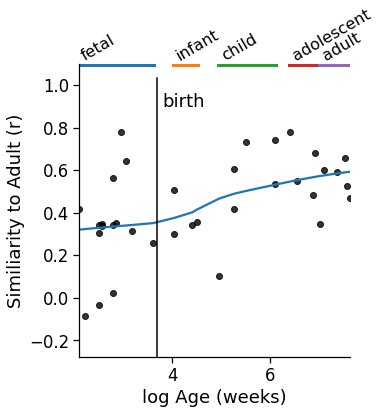

r=0.831, p=0.0


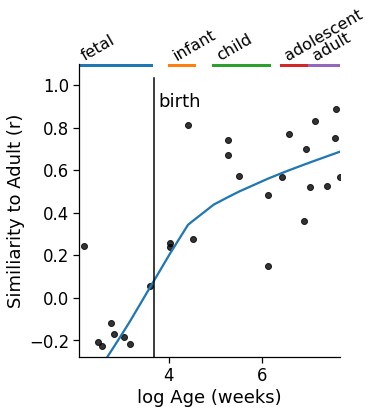

r=0.795, p=0.0


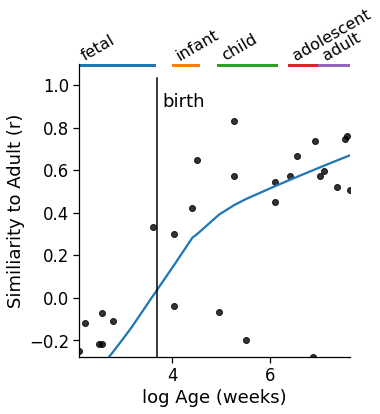

In [178]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 
pals = ['cividis','viridis','magma']

sns.set_context('notebook',font_scale=1.5)
# for each component
for bdim,adim in dims.items():
    # plot
    g=sns.lmplot(x='log_age_weeks',y='%s_r'%bdim,
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['%s_r'%bdim,'age_level']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['%s_r'%bdim].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     # make line purty
#     x, y = g.ax.get_lines()[0].get_data()
#     segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
#     norm = plt.Normalize(x.min(), x.max())
#     lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
#     lc.set_array(x[:-1])
#     lc.set_linewidth(2)
#     g.ax.get_lines()[0].remove()
#     line = g.ax.add_collection(lc)
#     plt.setp(line,linewidth=5)
    
    # decorate so age stage is indicated
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.28,1.1)
    ymin = subsum['%s_r'%bdim].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.9,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



r=0.865, p=0.0


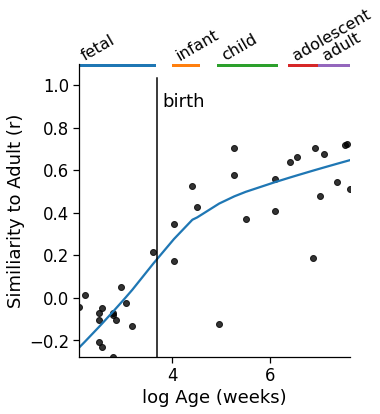

In [181]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 
pals = ['cividis','viridis','magma']

sns.set_context('notebook',font_scale=1.5)
# for each component
for bdim in ['mean_x_dimensions']:
    # plot
    g=sns.lmplot(x='log_age_weeks',y='%s_r'%bdim,
                lowess=True,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['%s_r'%bdim,'age_level']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['%s_r'%bdim].values,
                      plotr.age_level.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     # make line purty
#     x, y = g.ax.get_lines()[0].get_data()
#     segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
#     norm = plt.Normalize(x.min(), x.max())
#     lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
#     lc.set_array(x[:-1])
#     lc.set_linewidth(2)
#     g.ax.get_lines()[0].remove()
#     line = g.ax.add_collection(lc)
#     plt.setp(line,linewidth=5)
    
    # decorate so age stage is indicated
    for stage in gdf.Age_Stage.unique():
        levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.28,1.1)
    ymin = subsum['%s_r'%bdim].min() - 0.1
    plt.axvline(np.log(40),ymax=0.95,c='k')
    plt.text(np.log(40)+0.1,0.9,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    


In [69]:
# gxp.columns = [int(x) for x in gxp.columns]
# mmmod = MinMaxScaler().fit(gxp.T.loc[gdf[gdf.Age_Stage=='adult'].index])

# hb_pcatfm = pcamod.transform(MinMaxScaler().fit_transform(gxp).T)
# xtfm = pls_mod.transform(hb_pcatfm)
#preds = pls_mod.predict(hb_pcatfm)

In [26]:
from sklearn.cross_decomposition import PLSRegression
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

gxp.columns = [int(x) for x in gxp.columns]
mmmod = MinMaxScaler().fit(gxp.T.loc[gdf[gdf.Age_Stage=='adult'].index])

hb_pcatfm = pcamod.transform(mmmod.transform(gxp.T))
xtfm = pls_mod.transform(hb_pcatfm)

In [129]:
# xtfm = pls_mod.transform(hb_pcatfm)

In [28]:
n_comps=3
for c in range(n_comps):
    gdf.loc[:,'C%s_exp'%(c+1)] = xtfm[:,c]

# Genetic distance analysis

In [173]:
gxp.shape

(13750, 524)

In [184]:
donor = 13058
sdf = gdf[gdf.donor_id==donor]
# for col in ['age', 'gender','Age_Stage','log_age_weeks','zC1_exp', 'zC2_exp', 'zC3_exp']:
#     dists.loc[donor,col] = sdf[col].values[0]
#dists.loc[donor,'n_regions'] = len(sdf)
withins = []
betweens = []
dmat = gxp[sdf.index]
for col in dmat.columns:
    withins.append(np.mean(distance.pdist(dmat[col].values.reshape(-1,1))))
    for ccol in dmat.columns:
        if col == ccol:
            continue 
        else:
            betweens.append(np.mean(distance.cdist(dmat[col].values.reshape(-1,1),
                                                   dmat[ccol].values.reshape(-1,1))))
            


In [191]:
from scipy.spatial import distance

In [ ]:
distance

In [201]:
np.mean(distance.cdist(gxp[sdf.index].iloc[:,0].values.reshape(-1,1),
                      gxp[sdf.index].iloc[:,1].values.reshape(-1,1)))

21.078104101140468

In [206]:
dists = pandas.DataFrame(index = gdf.donor_id.unique())
for donor in gdf.donor_id.unique():
    print('working on donor',donor)
    sdf = gdf[gdf.donor_id==donor]
    for col in ['age', 'gender','Age_Stage','log_age_weeks','zC1_exp', 'zC2_exp', 'zC3_exp']:
        dists.loc[donor,col] = sdf[col].values[0]
    dists.loc[donor,'n_regions'] = len(sdf)
    withins = []
    betweens = []
    dmat = gxp[sdf.index]
    combos = []
    for col in dmat.columns:
        print(col)
        withins.append(np.mean(distance.pdist(dmat[col].values.reshape(-1,1))))
        for ccol in dmat.columns:
            if col == ccol or col+ccol in combos:
                continue 
            else:
                betweens.append(np.mean(distance.cdist(dmat[col].values.reshape(-1,1),
                                                       dmat[ccol].values.reshape(-1,1))))
                combos.append(col+ccol)
    dists.loc[donor,'mean_between'] = np.mean(betweens)
    dists.loc[donor,'mean_within'] = np.mean(withins)

working on donor 13058
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
working on donor 12833
16
17
18
19
20
21
22
23
24
25
26
27
28
29
working on donor 12835
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
working on donor 12960
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
working on donor 13060
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
working on donor 12820
75
76
77
78
79
80
81
82
83
84
85
86
87
88
working on donor 12834
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
working on donor 12888
105
106
107
108
109
110
111
112
113
114
115
116
117
118
working on donor 12287
119
120
121
122
123
124
125
126
127
128
working on donor 12837
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
working on donor 12879
145
146
147
148
149
150
151
152
153
154
155
156
157
working on donor 12880
158
159
160
161
162
163
164
165
166
167
168
169
170
171
working on donor 12885
172
173
174
175
176
177
178
179
180
181
182
working on donor 12365
183
184
working on donor 12886
185
186
187
188
189
190
1

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


working on donor 12949
216
217
218
working on donor 12295
219
220
working on donor 263195015
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
working on donor 12296
237
238
239
240
241
242
243
244
245
working on donor 12889
246
247
248
249
250
251
252
253
working on donor 12890
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
working on donor 12977
270
271
272
273
274
275
276
277
278
279
working on donor 12830
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
working on donor 12979
296
297
298
299
300
301
302
303
304
305
306
307
working on donor 12836
308
309
310
311
312
313
314
315
316
317
318
working on donor 12980
319
320
321
322
323
324
325
326
327
328
329
330
331
332
working on donor 12298
333
334
335
336
337
338
339
working on donor 12841
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
working on donor 12981
356
357
358
359
360
361
362
363
364
365
366
working on donor 12289
367
368
369
370
371
372
373
374
375
376
377
378

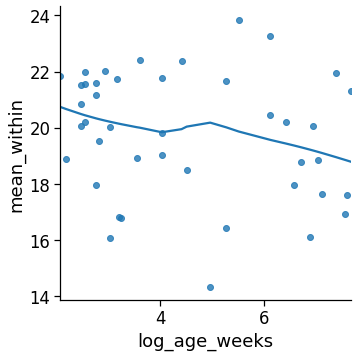

In [211]:
sns.lmplot(x='log_age_weeks',y='mean_within',data=dists,lowess=True)

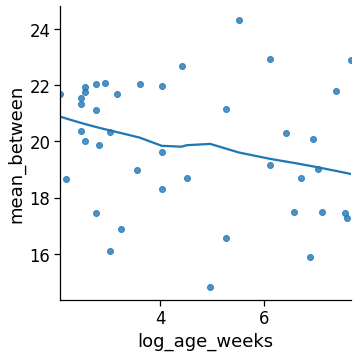

In [210]:
sns.lmplot(x='log_age_weeks',y='mean_between',data=dists,lowess=True)